In [1]:
### load data
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

Using TensorFlow backend.
/home/tutysara/anaconda2/envs/dog-project/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)

In [3]:
# check if running on gpu, method1
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [4]:
# check if running on gpu, method2
with tf.device('/cpu:0'):
  a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
  b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


In [5]:
train_files[:5]

array(['dogImages/train/095.Kuvasz/Kuvasz_06442.jpg',
       'dogImages/train/057.Dalmatian/Dalmatian_04054.jpg',
       'dogImages/train/088.Irish_water_spaniel/Irish_water_spaniel_06014.jpg',
       'dogImages/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00596.jpg',
       'dogImages/train/008.American_staffordshire_terrier/American_staffordshire_terrier_00563.jpg'],
      dtype='<U99')

## Human face detector

In [6]:
# import human dataset
import random
random.seed(4)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


In [7]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [8]:
# helper functions
def plot_image(img_path):
    img = cv2.imread(img_path)
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
def plot_image_plain(img_path):
    img = cv2.imread(img_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

In [9]:
# try using resnet
from keras.applications.mobilenet import MobileNet
# define Mobilenet model
MobileNet_model = MobileNet(weights='imagenet')

In [10]:
# convert and load images
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [21]:
# load and preprocess data
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')
valid_tensors = paths_to_tensor(valid_files).astype('float32')
test_tensors = paths_to_tensor(test_files).astype('float32')

100%|██████████| 836/836 [00:07<00:00, 118.60it/s]


In [22]:
print(train_tensors.shape)
print(valid_tensors.shape) 
print(test_tensors.shape) 

(6680, 224, 224, 3)
(835, 224, 224, 3)
(836, 224, 224, 3)


In [50]:
# preprocess image for using with imagenet predictions
def predict_labels(img_path):
    from keras.applications.mobilenet import preprocess_input, decode_predictions
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(MobileNet_model.predict(img))

In [24]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [25]:
import keras.backend as k
k.image_data_format()

'channels_last'

In [26]:
from keras.applications.mobilenet import MobileNet, preprocess_input

bnf_train_name = 'bottleneck_features_mobilenet_train.npy'
bnf_test_name = 'bottleneck_features_mobilenet_test.npy' 
bnf_valid_name = 'bottleneck_features_mobilenet_valid.npy'

mobilenet_feature_ext = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

bottleneck_features_train = mobilenet_feature_ext.predict(preprocess_input(train_tensors))
np.save(open(bnf_train_name, 'wb'),bottleneck_features_train)

bottleneck_features_validation = mobilenet_feature_ext.predict(preprocess_input(valid_tensors))
np.save(open(bnf_test_name, 'wb'),bottleneck_features_validation)

bottleneck_features_test = mobilenet_feature_ext.predict(preprocess_input(test_tensors))
np.save(open(bnf_valid_name, 'wb'),bottleneck_features_test)

In [27]:
# load convered data back
train_data = np.load(open(bnf_train_name, 'rb'))
train_labels = train_targets[:train_data.shape[0]]
validation_data = np.load(open(bnf_test_name, 'rb'))
validation_labels = valid_targets[:validation_data.shape[0]]
test_data = np.load(open(bnf_valid_name, 'rb'))
test_labels = test_targets[:test_data.shape[0]]

In [28]:
print(train_tensors.shape, train_targets.shape)
print(train_data.shape, train_labels.shape)
print(validation_data.shape, validation_labels.shape)
print(test_data.shape, test_labels.shape)


(6680, 224, 224, 3) (6680, 133)
(6680, 7, 7, 1024) (6680, 133)
(835, 7, 7, 1024) (835, 133)
(836, 7, 7, 1024) (836, 133)


In [33]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import regularizers

model = Sequential()
#model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(133, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 593,029
Trainable params: 593,029
Non-trainable params: 0
_________________________________________________________________


In [34]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
#checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.mymodel.resnet50.hdf5', verbose=1, save_best_only=True)
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.mymodel.mobilenet.hdf5', verbose=1, save_best_only=True)
model.fit(train_data[:150], train_labels[:150],
          epochs=25,
          batch_size=64,
          validation_data=(validation_data[:50], validation_labels[:50]),
          callbacks=[early_stopping])

Train on 150 samples, validate on 50 samples
Epoch 1/25
150/150 [==============================] - 1s 4ms/step - loss: 5.5569 - acc: 0.0133 - val_loss: 4.8136 - val_acc: 0.0400
Epoch 2/25
150/150 [==============================] - 0s 357us/step - loss: 4.1074 - acc: 0.1133 - val_loss: 4.7772 - val_acc: 0.1000
Epoch 3/25
150/150 [==============================] - 0s 332us/step - loss: 3.3407 - acc: 0.2000 - val_loss: 4.8329 - val_acc: 0.1400
Epoch 4/25
150/150 [==============================] - 0s 339us/step - loss: 2.5399 - acc: 0.4467 - val_loss: 4.8246 - val_acc: 0.2000
Epoch 5/25
150/150 [==============================] - 0s 333us/step - loss: 1.8032 - acc: 0.7067 - val_loss: 4.9467 - val_acc: 0.1600
Epoch 6/25
150/150 [==============================] - 0s 333us/step - loss: 1.2357 - acc: 0.7800 - val_loss: 5.0373 - val_acc: 0.2200
Epoch 00006: early stopping


In [35]:
### train accuracy
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in train_data[:150]]

# report test accuracy
train_accuracy = 100*np.sum(np.array(predictions)==np.argmax(train_labels[:150], axis=1))/len(predictions)
print('Train accuracy: %.4f%%' % train_accuracy)

Train accuracy: 98.0000%


In [36]:
### test accuracy
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_data[:50]]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_labels[:50], axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 28.0000%


In [37]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
#checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.mymodel.resnet50.hdf5', verbose=1, save_best_only=True)
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.mymodel.mobilenet.hdf5', verbose=1, save_best_only=True)
model.fit(train_data, train_labels,
          epochs=25,
          batch_size=64,
          validation_data=(validation_data, validation_labels),
          callbacks=[early_stopping, checkpointer])

Train on 6680 samples, validate on 835 samples
Epoch 1/25
6680/6680 [==============================] - 2s 334us/step - loss: 2.4130 - acc: 0.4251 - val_loss: 1.0488 - val_acc: 0.6994
Epoch 2/25
6680/6680 [==============================] - 2s 281us/step - loss: 0.8971 - acc: 0.7263 - val_loss: 0.7479 - val_acc: 0.7868
Epoch 3/25
6680/6680 [==============================] - 2s 277us/step - loss: 0.6076 - acc: 0.8076 - val_loss: 0.6769 - val_acc: 0.7928
Epoch 4/25
6680/6680 [==============================] - 2s 278us/step - loss: 0.4324 - acc: 0.8642 - val_loss: 0.6624 - val_acc: 0.7940
Epoch 5/25
6680/6680 [==============================] - 2s 276us/step - loss: 0.3528 - acc: 0.8868 - val_loss: 0.5729 - val_acc: 0.8228
Epoch 6/25
6680/6680 [==============================] - 2s 272us/step - loss: 0.3009 - acc: 0.9046 - val_loss: 0.5947 - val_acc: 0.8120
Epoch 7/25
6680/6680 [==============================] - 2s 273us/step - loss: 0.2280 - acc: 0.9283 - val_loss: 0.5755 - val_acc: 0.8108
E

In [38]:
### train accuracy
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in train_data[:150]]

# report test accuracy
train_accuracy = 100*np.sum(np.array(predictions)==np.argmax(train_labels[:150], axis=1))/len(predictions)
print('Train accuracy: %.4f%%' % train_accuracy)

Train accuracy: 98.6667%


In [39]:
### test accuracy
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_data]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_labels, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.6986%


In [40]:
def extract(tensor, model, preprocess_input):
    return model.predict(preprocess_input(tensor))

In [42]:
from keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input
def predict_breed(img_path):
    # extract bottleneck features
    #bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    bottleneck_feature = extract(path_to_tensor(img_path), mobilenet_feature_ext, mobilenet_preprocess_input)
    # obtain predicted vector
    predicted_vector = model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [43]:
bottleneck_feature = extract(path_to_tensor("trisha.jpg"), mobilenet_feature_ext, mobilenet_preprocess_input)

In [44]:
bottleneck_feature = path_to_tensor("trisha.jpg")
bottleneck_feature.shape


(1, 224, 224, 3)

In [45]:
#predict_breed("lfw/Jennifer_Renee_Short/Jennifer_Renee_Short_0001.jpg")
predict_breed("trisha.jpg")

'Dachshund'

In [46]:
def detect_breed(img_path):
    is_dog = False
    is_human = False
    if dog_detector(img_path):
        is_dog = True
    elif face_detector(img_path):
        is_human = True
    else:
        print("No dog or humans found")
        plot_image_plain(img_path)
        return
    dog_breed = predict_breed(img_path)
    if(is_human):
        print("Hey there...")
        plot_image_plain(img_path)
        print("You look like a...\n {dog_breed}".format(dog_breed=dog_breed))
    else:
        plot_image_plain(img_path)
        print("This look like a...\n {dog_breed}".format(dog_breed=dog_breed))
        

time taken 11.361452102661133
No dog or humans found


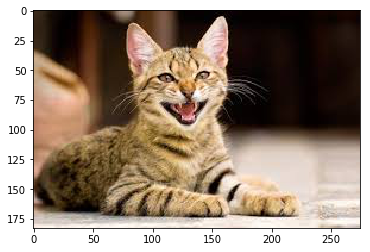

Hey there...


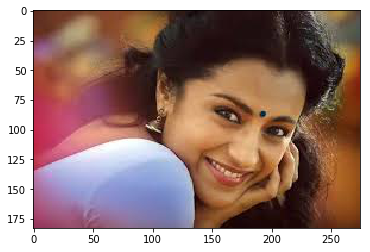

You look like a...
 Dachshund
Hey there...


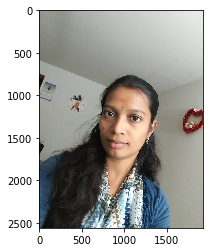

You look like a...
 Havanese
Hey there...


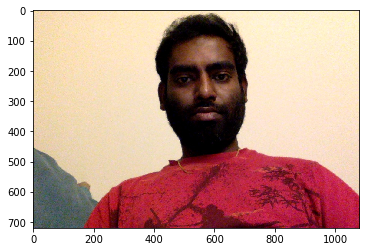

You look like a...
 Dogue_de_bordeaux
Hey there...


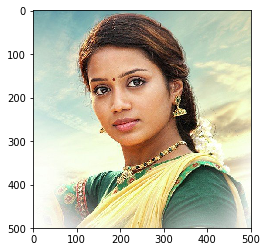

You look like a...
 Pomeranian


In [58]:
#detect_breed("lfw/Jennifer_Renee_Short/Jennifer_Renee_Short_0001.jpg")
#detect_breed("dhana.jpg")
import time
t0 = time.time()
for i in range(1, 2):
    predict_breed("trisha.jpg")
print("time taken", time.time()-t0)
detect_breed("cat.jpg")
detect_breed("trisha.jpg")
detect_breed("dhana.jpg")
detect_breed("sara.jpg")
detect_breed("nivetha2.jpg")